<a href="https://colab.research.google.com/github/rajaramesh-ds/datascience/blob/master/Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

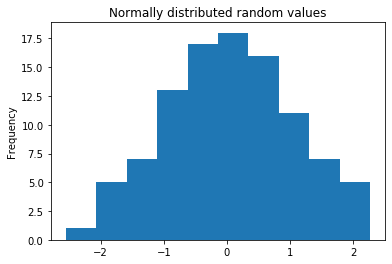

In [0]:
import pandas as pd # This is always assumed but is included here as an introduction.
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
values = np.random.randn(100) # array of normally distributed random numbers
s = pd.Series(values) # generate a pandas series
s.plot(kind='hist', title='Normally distributed random values') # hist computes distribution
plt.show()

In [0]:
s.describe()

count    100.000000
mean       0.059808
std        1.012960
min       -2.552990
25%       -0.643857
50%        0.094096
75%        0.737077
max        2.269755
dtype: float64

In [0]:
df = pd.DataFrame({'A': [1, 2, 1, 4, 3, 5, 2, 3, 4, 1],
'B': [12, 14, 11, 16, 18, 18, 22, 13, 21, 17],
'C': ['a', 'a', 'b', 'a', 'b', 'c', 'b', 'a', 'b', 'a']})

In [0]:
df

,A,B,C
0,1,12,a
1,2,14,a
2,1,11,b
3,4,16,a
4,3,18,b
5,5,18,c
6,2,22,b
7,3,13,a
8,4,21,b
9,1,17,a


In [0]:
df.describe()

,A,B
count,10.000000,10.000000
mean,2.600000,16.200000
std,1.429841,3.705851
min,1.000000,11.000000
25%,1.250000,13.250000
50%,2.500000,16.500000
75%,3.750000,18.000000
max,5.000000,22.000000


In [0]:
df['C'].describe()

count     10
unique     3
top        a
freq       5
Name: C, dtype: object

In [0]:
import pandas as pd
import numpy as np
num_securities = 1000
num_periods = 1000
period_frequency = 'W'

start_date = '2000-12-31'
np.random.seed([3,1415])
means = [0, 0]
covariance = [[ 1., 5e-3],
[5e-3, 1.]]
# generates to sets of data m[0] and m[1] with ~0.005 correlation
m = np.random.multivariate_normal(means, covariance,
(num_periods, num_securities)).T

In [0]:
ids = pd.Index(['s{:05d}'.format(s) for s in range(num_securities)], 'ID')
tidx = pd.date_range(start=start_date, periods=num_periods, freq=period_frequency)

In [0]:
security_returns = pd.DataFrame(m[0] / 25 + 1e-7, tidx, ids)
security_signals = pd.DataFrame(m[1], tidx, ids)

In [0]:
def qcut(s, q=5):
  labels = ['q{}'.format(i) for i in range(1, 6)]
  return pd.qcut(s, q, labels=labels)
cut = security_signals.stack().groupby(level=0).apply(qcut)

In [0]:
returns_cut = security_returns.stack().rename('returns') \
.to_frame().set_index(cut, append=True) \
.swaplevel(2, 1).sort_index().squeeze() \
.groupby(level=[0, 1]).mean().unstack()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  del sys.path[0]


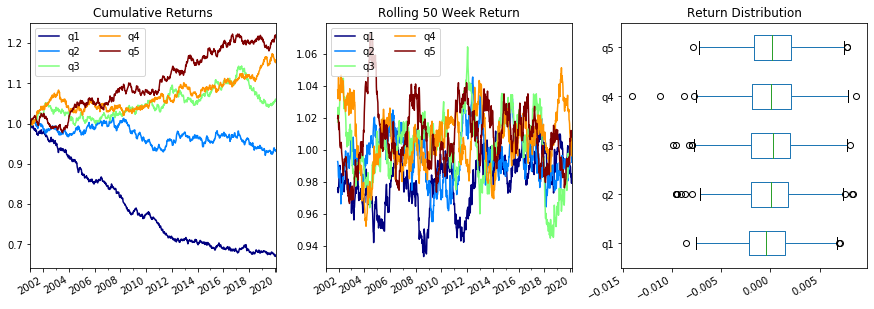

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

# Cumulative Returns
returns_cut.add(1).cumprod() \
.plot(colormap='jet', ax=ax1, title="Cumulative Returns")
leg1 = ax1.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg1.get_frame().set_alpha(.8)

# Rolling 50 Week Return
returns_cut.add(1).rolling(50).apply(lambda x: x.prod()) \
.plot(colormap='jet', ax=ax2, title="Rolling 50 Week Return")
leg2 = ax2.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg2.get_frame().set_alpha(.8)

# Return Distribution
returns_cut.plot.box(vert=False, ax=ax3, title="Return Distribution")
fig.autofmt_xdate()
plt.show()


In [0]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(returns_cut, alpha=0.5, figsize=(8, 8), diagonal='hist')
plt.show()

ModuleNotFoundError: ignored

In [0]:
def max_dd(returns):
  """returns is a series"""
  r = returns.add(1).cumprod()
  dd = r.div(r.cummax()).sub(1)
  mdd = dd.min()
  end = dd.argmin()
  start = r.loc[:end].argmax()
  return mdd, start, end
def max_dd_df(returns):
  """returns is a dataframe"""
  series = lambda x: pd.Series(x, ['Draw Down', 'Start', 'End'])
  return returns.apply(max_dd).apply(series)

In [0]:
max_dd_df(returns_cut)

In [0]:
draw_downs = max_dd_df(returns_cut)
fig, axes = plt.subplots(5, 1, figsize=(10, 8))
for i, ax in enumerate(axes[::-1]):
  returns_cut.iloc[:, i].add(1).cumprod().plot(ax=ax)
sd, ed = draw_downs[['Start', 'End']].iloc[i]
ax.axvspan(sd, ed, alpha=0.1, color='r')
ax.set_ylabel(returns_cut.columns[i])
fig.suptitle('Maximum Draw Down', fontsize=18)
fig.tight_layout()
plt.subplots_adjust(top=.95)

In [0]:
def frequency_of_time_series(df):
  start, end = df.index.min(), df.index.max()
  delta = end - start
  return round((len(df) - 1.) * 365.25 / delta.days, 2)
def annualized_return(df):
  freq = frequency_of_time_series(df)
  return df.add(1).prod() ** (1 / freq) - 1
def annualized_volatility(df):
  freq = frequency_of_time_series(df)
  return df.std().mul(freq ** .5)
def sharpe_ratio(df):
  return annualized_return(df) / annualized_volatility(df)
def describe(df):
  r = annualized_return(df).rename('Return')
  v = annualized_volatility(df).rename('Volatility')
  s = sharpe_ratio(df).rename('Sharpe')
  skew = df.skew().rename('Skew')
  kurt = df.kurt().rename('Kurtosis')
  desc = df.describe().T
  return pd.concat([r, v, s, skew, kurt, desc], axis=1).T.drop('count')


In [0]:
describe(returns_cut)

In [0]:
import pandas as pd
df = pd.DataFrame(columns = ['A', 'B', 'C'])
df

In [0]:
df.loc[0, 'A'] = 1
df

In [0]:
df.loc[1] = [2, 3, 4]
df


In [0]:
df.loc[2] = {'A': 3, 'C': 9, 'B': 9}
df

In [0]:
df.loc[1] = [5, 6, 7]
df

In [0]:
df.loc[0, 'B'] = 8
df

In [0]:
df1 = pd.DataFrame(columns = ['A', 'B'])
df2 = pd.DataFrame(columns = ['B', 'C'])

In [0]:
df1.loc[0] = ['a1','b1']
df1.loc[1] = ['a2','b2']
df2.loc[1] = ['b1','c1']

In [0]:
df1


In [0]:
df2

In [0]:
df1.append(df2)

In [0]:
df1.append(df2, ignore_index=True)

# ***`Chapter 4: Boolean indexing of dataframes`***

In [0]:
df = pd.DataFrame({"color": ['red', 'blue', 'red', 'blue']},
index=[True, False, True, False])

In [278]:
df

,color
True,red
False,blue
True,red
False,blue


In [0]:
df.loc[True]

In [0]:
df.iloc[True]

In [0]:
df.iloc[1]

In [0]:
df.ix[True]

In [0]:
df.ix[1]

In [288]:
df = pd.DataFrame({"color": ['red', 'blue', 'red', 'blue'], "name": ['rose','violet','tulip','harebell'], "size": ['big', 'big', 'small', 'small']})
df

,color,name,size
0,red,rose,big
1,blue,violet,big
2,red,tulip,small
3,blue,harebell,small


In [289]:
df[[True, False, False, True]]

,color,name,size
0,red,rose,big
3,blue,harebell,small


In [290]:
df['size'] == 'small'

0    False
1    False
2     True
3     True
Name: size, dtype: bool

In [291]:
size_small_mask = df['size'] == 'small'
df[size_small_mask]

,color,name,size
2,red,tulip,small
3,blue,harebell,small


In [292]:
size_small_mask.__getitem__

<bound method Series.__getitem__ of 0    False
1    False
2     True
3     True
Name: size, dtype: bool>

In [293]:
size_small_mask.__getitem__(0)

False

In [294]:
df

,color,name,size
0,red,rose,big
1,blue,violet,big
2,red,tulip,small
3,blue,harebell,small


In [0]:
df = df.set_index('name')

In [296]:
df

,color,size
name,,
rose,red,big
violet,blue,big
tulip,red,small
harebell,blue,small


In [0]:
rose_mask = df.index == 'rose'
df[rose_mask]

In [0]:
df.loc['rose']

In [0]:
df.loc[['rose']]

# ***Chapter 5: Categorical data***

In [0]:
s = pd.Series(["a","b","c","a","c"], dtype="category")

In [0]:
s

In [0]:
df = pd.DataFrame({"A":["a","b","c","a", "c"]})

In [0]:
df["B"] = df["A"].astype('category')

In [0]:
df["C"] = pd.Categorical(df["A"])

In [0]:
df

In [0]:
df["D"] = df["A"].astype('category')

In [0]:
df.dtypes

In [0]:
df1 = pd.DataFrame({"A":["a","b","c","a", "c"]}, dtype="category")

In [0]:
df1["E"] = df1["A"]

In [0]:
df1.dtypes

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.DataFrame(np.random.choice(['foo','bar','baz'], size=(100000,3)))
df = df.apply(lambda col: col.astype('category'))

In [0]:
df.head()

In [0]:
df.dtypes

In [0]:
df.shape

# ***Chapter 6: Computational Tools***

In [0]:
df = pd.DataFrame(np.random.randn(1000, 3), columns=['a', 'b', 'c'])

In [0]:
df.corr()

In [0]:
df.corr(method='spearman')

# ***Chapter 7: Creating DataFrames***

In [0]:
import pandas as pd

In [0]:
df = pd.DataFrame({'numbers': [1, 2, 3], 'colors': ['red', 'white', 'blue']})

In [0]:
df

In [0]:
print(df)

In [0]:
df = pd.DataFrame({'numbers': [1, 2, 3], 'colors': ['red', 'white', 'blue']},
columns=['numbers', 'colors'])

In [0]:
print(df)

In [0]:
import numpy as np
import pandas as pd
# Set the seed for a reproducible sample
np.random.seed(0)
df = pd.DataFrame(np.random.randn(5, 3), columns=list('ABC'))
print(df)

In [0]:
df = pd.DataFrame(np.arange(15).reshape(5,3),columns=list('ABC'))
print(df)

In [0]:
df = pd.DataFrame(np.arange(48).reshape(8,6),columns=list('ABCDEF'))
print(df)
# Output:
# A B C D E F
# 0 0 1 2 3 4 5
# 1 6 7 8 9 10 11
# 2 12 13 14 15 16 17
# 3 18 19 20 21 22 23
# 4 24 25 26 27 28 29
# 5 30 31 32 33 34 35
# 6 36 37 38 39 40 41
# 7 42 43 44 45 46 47


In [0]:
df.ix[::2,0] = np.nan # in column 0, set elements with indices 0,2,4, ... to NaN
df.ix[::4,1] = pd.NaT # in column 1, set elements with indices 0,4, ... to np.NaT
df.ix[:3,2] = 'nan' # in column 2, set elements with index from 0 to 3 to 'nan'
df.ix[:,5] = None # in column 5, set all elements to None
df.ix[5,:] = None # in row 5, set all elements to None
df.ix[7,:] = np.nan # in row 7, set all elements to NaN
print(df)
# Output:
# A B C D E F
# 0 NaN NaT nan 3 4 None
# 1 6 7 nan 9 10 None
# 2 NaN 13 nan 15 16 None
# 3 18 19 nan 21 22 None
# 4 NaN NaT 26 27 28 None
# 5 NaN None None NaN NaN None
# 6 NaN 37 38 39 40 None
# 7 NaN NaN NaN NaN NaN NaN

In [0]:
import pandas as pd
import numpy as np
np.random.seed(123)
x = np.random.standard_normal(4)
y = range(4)
df = pd.DataFrame({'X':x, 'Y':y})


In [0]:
df


In [0]:
print(df)

In [0]:
import pandas as pd
data = [
('p1', 't1', 1, 2),
('p1', 't2', 3, 4),
('p2', 't1', 5, 6),
('p2', 't2', 7, 8),
('p2', 't3', 2, 8)
]
df = pd.DataFrame(data)
print(df)

In [0]:
import pandas as pd
# Create DF from dict of lists/ndarrays
df = pd.DataFrame({'A' : [1, 2, 3, 4],
'B' : [4, 3, 2, 1]})
df
# Output:
# A B
# 0 1 4
# 1 2 3
# 2 3 2
# 3 4 1

In [0]:
df = pd.DataFrame({'A' : [1, 2, 3, 4], 'B' : [5, 5, 5]}) # a ValueError is raised

In [0]:
import pandas as pd
import numpy as np
np.random.seed(123)
x = np.random.standard_normal(4)
y = range(4)
df = pd.DataFrame({'X':x, 'Y':y})
df

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)
# create an array of 5 dates starting at '2015-02-24', one per minute
rng = pd.date_range('2015-02-24', periods=5, freq='T')
df = pd.DataFrame({ 'Date': rng, 'Val': np.random.randn(len(rng)) })
print (df)

In [0]:
# create an array of 5 dates starting at '2015-02-24', one per day
rng = pd.date_range('2015-02-26', periods=5, freq='D')
df = pd.DataFrame({ 'Date': rng, 'Val' : np.random.randn(len(rng))})
print (df)


In [0]:
# create an array of 5 dates starting at '2015-02-24', one every 3 years
rng = pd.date_range('2015-02-24', periods=5, freq='3A')
df = pd.DataFrame({ 'Date': rng, 'Val' : np.random.randn(len(rng))})
print (df)

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)
rng = pd.date_range('2015-02-24', periods=5, freq='T')
df = pd.DataFrame({ 'Val' : np.random.randn(len(rng)) }, index=rng)
print (df)

In [0]:
#Alias Description
#####################
#B business day frequency
#C custom business day frequency (experimental)
#D calendar day frequency
#W weekly frequency
#M month end frequency
#BM business month end frequency
#CBM custom business month end frequency
#MS month start frequency
#BMS business month start frequency
#CBMS custom business month start frequency
#Q quarter end frequency
#BQ business quarter endfrequency
#QS quarter start frequency
#BQS business quarter start frequency
#A year end frequency
#BA business year end frequency
#AS year start frequency
#BAS business year start frequency
#BH business hour frequency
#H hourly frequency
#T, min minutely frequency
#S secondly frequency
#L, ms milliseconds
#U, us microseconds
#N nanoseconds

In [0]:
import pandas as pd
import numpy as np

In [0]:
np.random.seed(0)
tuples = list(zip(*[['bar', 'bar', 'baz', 'baz',
'foo', 'foo', 'qux', 'qux'],
['one', 'two', 'one', 'two',
'one', 'two', 'one', 'two']]))
idx = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])

In [0]:
idx = pd.MultiIndex.from_product([['bar', 'baz', 'foo', 'qux'],['one','two']])

In [0]:
df = pd.DataFrame(np.random.randn(8, 2), index=idx, columns=['A', 'B'])
print (df)

In [0]:
import pandas as pd

In [0]:
# Save dataframe to pickled pandas object
df.to_pickle(file_name) # where to save it usually as a .plk
# Load dataframe from pickled pandas object
df= pd.read_pickle(file_name)

In [0]:
import pandas as pd
L = [{'Name': 'John', 'Last Name': 'Smith'},
{'Name': 'Mary', 'Last Name': 'Wood'}]
pd.DataFrame(L)

In [0]:
L = [{'Name': 'John', 'Last Name': 'Smith', 'Age': 37},
{'Name': 'Mary', 'Last Name': 'Wood'}]
pd.DataFrame(L)

In [0]:
import pandas as pd
import numpy as np
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
idx_row = pd.MultiIndex.from_arrays(arrays, names=['Row_First', 'Row_Second'])
idx_col = pd.MultiIndex.from_product([['A','B'], ['i', 'ii']],
names=['Col_First','Col_Second'])
df = pd.DataFrame(np.random.randn(8,4), index=idx_row, columns=idx_col)

In [0]:
df.xs('two', level='Row_Second', axis=0)

In [0]:
df.xs('ii', level=1, axis=1)

In [0]:
df.xs('ii', level='Col_Second', axis=1) = 0

In [0]:
import pandas as pd
import numpy as np
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
idx_row = pd.MultiIndex.from_arrays(arrays, names=['Row_First', 'Row_Second'])
idx_col = pd.MultiIndex.from_product([['A','B'], ['i', 'ii']],
names=['Col_First','Col_Second'])
df = pd.DataFrame(np.random.randn(8,4), index=idx_row, columns=idx_col)

In [0]:
df.loc[(slice(None),'two'),:]

In [0]:
df.loc[:,(slice(None),'ii')]

In [0]:
df.loc[(slice(None),'two'),(slice(None),'ii')]

In [0]:
df.loc[(slice(None),'two'),(slice(None),'ii')]=0


In [0]:
df

In [0]:
pd.Series([1.,2.,3.,4.,5.]).astype(object)

In [0]:
type(pd.Series([1.,2.,3.,4.,5.]).astype(object)[0])

In [0]:
pd.Series([1.,2.,3.,4.,5.]).astype(str)

In [0]:
type(pd.Series([1.,2.,3.,4.,5.]).astype(str)[0])

In [0]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': [True, False, True]})

In [0]:
df

In [0]:
df.dtypes

In [0]:
df['A'].dtype

In [0]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0],
'C': ['1.1.2010', '2.1.2011', '3.1.2011'],
'D': ['1 days', '2 days', '3 days'],
'E': ['1', '2', '3']})

In [0]:
df

In [0]:
df.dtypes

In [0]:
df['A'].astype('float')

In [0]:
df['B'].astype('int')

In [0]:
pd.to_numeric(df['E'])

In [0]:
pd.to_numeric(pd.Series(['1', '2', 'a']), errors='ignore')

In [0]:
pd.to_numeric(pd.Series(['1', '2', 'a']), errors='coerce')

In [0]:
df = pd.DataFrame({'A': [1, 'x', 'z'],
'B': [1.0, 2.0, 3.0],
'C': [True, False, True]})

In [0]:
pd.to_numeric(df.A, errors='coerce').isnull()

In [0]:
df[pd.to_numeric(df.A, errors='coerce').isnull()]

In [0]:
pd.to_datetime(df['C'])

In [0]:
pd.to_datetime('2.1.2011', dayfirst=True)

In [0]:
pd.to_timedelta(df['D'])

In [0]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'],
'D': [True, False, True]})

In [0]:
df

In [0]:
# Select numbers
df.select_dtypes(include=['number']) # You need to use a list

In [0]:
# Select numbers and booleans
df.select_dtypes(include=['number', 'bool'])

In [0]:
# Select numbers and booleans but exclude int64
df.select_dtypes(include=['number', 'bool'], exclude=['int64'])

In [0]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'],
'D': [True, False, True]})

In [0]:
df.get_dtype_counts()

# ***Chapter 10: Dealing with categorical variables***

In [0]:
df = pd.DataFrame({'Name':['John Smith', 'Mary Brown'],
'Gender':['M', 'F'], 'Smoker':['Y', 'N']})
print(df)

In [0]:
df_with_dummies = pd.get_dummies(df, columns=['Gender', 'Smoker'])
print(df_with_dummies)

# ***Duplicated data***

In [0]:
df = pd.DataFrame({'A':[1,2,3,3,2],
'B':[1,7,3,0,8]})

In [0]:
mask = df.A.duplicated(keep=False)

In [0]:
mask

0    False
1     True
2     True
3     True
4     True
Name: A, dtype: bool

In [0]:
df.ix[mask, 'B'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [0]:
df['C'] = df.A.mask(mask, 0)

In [0]:
df

,A,B,C
0,1,1,1
1,2,0,0
2,3,0,0
3,3,0,0
4,2,0,0


In [0]:
df['C'] = df.A.mask(~mask, 0)

In [0]:
df

,A,B,C
0,1,1,0
1,2,0,2
2,3,0,3
3,3,0,3
4,2,0,2


In [0]:
df = pd.DataFrame({'A':[1,2,3,3,2], 'B':[1,7,3,0,8]})

In [0]:
df

,A,B
0,1,1
1,2,7
2,3,3
3,3,0
4,2,8


In [0]:
# keep only the last value
df.drop_duplicates(subset=['A'], keep='last')

,A,B
0,1,1
3,3,0
4,2,8


In [0]:
# keep only the first value, default value
df.drop_duplicates(subset=['A'], keep='first')

,A,B
0,1,1
1,2,7
2,3,3


In [0]:
# drop all duplicated values
df.drop_duplicates(subset=['A'], keep=False)

,A,B
0,1,1


In [0]:
df = pd.DataFrame({'A':[1,2,3,3,2], 'B':[1,7,3,0,8]})

In [0]:
df

,A,B
0,1,1
1,2,7
2,3,3
3,3,0
4,2,8


In [0]:
df.drop_duplicates(subset=['A'], inplace=True)

In [0]:
df

,A,B
0,1,1
1,2,7
2,3,3


In [0]:
id_numbers = pd.Series([111, 112, 112, 114, 115, 118, 114, 118, 112])

In [0]:
id_numbers.nunique()

5

In [0]:
id_numbers.unique()

array([111, 112, 114, 115, 118])

In [0]:
df = pd.DataFrame({'Group': list('ABAABABAAB'), 'ID': [1, 1, 2, 3, 3, 2, 1, 2, 1, 3]})

In [0]:
df

,Group,ID
0,A,1
1,B,1
2,A,2
3,A,3
4,B,3
5,A,2
6,B,1
7,A,2
8,A,1
9,B,3


In [0]:
df.groupby('Group')['ID'].nunique()

Group
A    3
B    2
Name: ID, dtype: int64

In [0]:
df.groupby('Group')['ID'].unique()

Group
A    [1, 2, 3]
B       [1, 3]
Name: ID, dtype: object

In [0]:
df = pd.DataFrame({"A":[1,1,2,3,1,1],"B":[5,4,3,4,6,7]})

In [0]:
df

,A,B
0,1,5
1,1,4
2,2,3
3,3,4
4,1,6
5,1,7


In [0]:
df["A"].unique()

array([1, 2, 3])

In [0]:
df["B"].unique()

array([5, 4, 3, 6, 7])

In [0]:
pd.unique(df['A']).tolist()

[1, 2, 3]

In [0]:
df.loc['4', 'B'] = 4

In [0]:
pd.unique(df[df['A'] == 1 ]['B']).tolist()

[5.0, 4.0, 6.0, 7.0]

In [0]:
df['A'] == 1

0     True
1     True
2    False
3    False
4     True
5     True
4    False
Name: A, dtype: bool

In [0]:
df[df['A'] == 1]['B'].tolist()

[5.0, 4.0, 6.0, 7.0]

# ***Chapter 12: Getting information about DataFrames***

In [0]:
import pandas as pd

In [0]:
df = pd.DataFrame({'integers': [1, 2, 3], 'floats': [1.5, 2.5, 3], 'text': ['a', 'b', 'c'], 'ints with None': [1, None, 3]})

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
integers          3 non-null int64
floats            3 non-null float64
text              3 non-null object
ints with None    2 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 224.0+ bytes


In [0]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
integers          3 non-null int64
floats            3 non-null float64
text              3 non-null object
ints with None    2 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 398.0 bytes


In [0]:
df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6], 'c': [7, 8, 9]})

In [0]:
list(df)

['a', 'b', 'c']

In [0]:
df

,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9


In [0]:
[c for c in df]

['a', 'b', 'c']

In [0]:
sampledf.columns.tolist()

NameError: ignored

In [0]:
df.columns

Index(['a', 'b', 'c'], dtype='object')

In [0]:
import pandas as pd
df = pd.DataFrame(np.random.randn(5, 5), columns=list('ABCDE'))

In [0]:
df

,A,B,C,D,E
0,1.492116,0.446860,-0.103405,-0.806945,-0.557569
1,-1.950547,1.356246,-0.858340,-0.504333,1.054679
2,0.094801,0.544635,-0.047499,0.961600,-2.975771
3,1.689000,1.304931,-0.899135,1.503714,-0.193128
4,1.481764,-1.766106,-1.182987,-0.955505,-0.666324


In [0]:
df.describe()

,A,B,C,D,E
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.561427,0.377313,-0.618273,0.039706,-0.667623
std,1.542107,1.269435,0.511442,1.117637,1.460405
min,-1.950547,-1.766106,-1.182987,-0.955505,-2.975771
25%,0.094801,0.446860,-0.899135,-0.806945,-0.666324
50%,1.481764,0.544635,-0.858340,-0.504333,-0.557569
75%,1.492116,1.304931,-0.103405,0.961600,-0.193128
max,1.689000,1.356246,-0.047499,1.503714,1.054679


# ***Chapter 13: Gotchas of pandas***

In [0]:
df=pd.DataFrame({'col':[1,np.nan]})
df==np.nan

,col
0,False
1,False


In [0]:
df=pd.DataFrame({'col':[1,np.nan]})
df.isnull()

,col
0,False
1,True


In [0]:
df = pd.read_csv("/content/FL_insurance_sample.csv", dtype={'policyID': int})

In [0]:
df

,policyID,statecode,county,eq_site_limit,hu_site_limit,fl_site_limit,fr_site_limit,tiv_2011,tiv_2012,eq_site_deductible,hu_site_deductible,fl_site_deductible,fr_site_deductible,point_latitude,point_longitude,line,construction,point_granularity
0,119736,FL,CLAY COUNTY,498960.0,498960.00,498960.0,498960.0,498960.00,792148.90,0.0,9979.2,0.0,0,30.102261,-81.711777,Residential,Masonry,1
1,448094,FL,CLAY COUNTY,1322376.3,1322376.30,1322376.3,1322376.3,1322376.30,1438163.57,0.0,0.0,0.0,0,30.063936,-81.707664,Residential,Masonry,3
2,206893,FL,CLAY COUNTY,190724.4,190724.40,190724.4,190724.4,190724.40,192476.78,0.0,0.0,0.0,0,30.089579,-81.700455,Residential,Wood,1
3,333743,FL,CLAY COUNTY,0.0,79520.76,0.0,0.0,79520.76,86854.48,0.0,0.0,0.0,0,30.063236,-81.707703,Residential,Wood,3
4,172534,FL,CLAY COUNTY,0.0,254281.50,0.0,254281.5,254281.50,246144.49,0.0,0.0,0.0,0,30.060614,-81.702675,Residential,Wood,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36629,404309,FL,PINELLAS COUNTY,0.0,88722.00,0.0,88722.0,88722.00,155065.65,0.0,0.0,0.0,0,28.122885,-82.770218,Residential,Wood,3
36630,465875,FL,PINELLAS COUNTY,1297057.5,1297057.50,1297057.5,1297057.5,1297057.50,1577500.79,0.0,0.0,0.0,0,28.080900,-82.758800,Residential,Masonry,1
36631,791209,FL,PINELLAS COUNTY,173286.9,173286.90,0.0,0.0,173286.90,205527.97,0.0,0.0,0.0,0,28.110550,-82.766360,Residential,Wood,4
36632,322627,FL,PINELLAS COUNTY,1499781.6,1499781.60,0.0,0.0,1499781.60,1768782.43,0.0,0.0,0.0,0,28.089415,-82.697411,Residential,Masonry,3


In [0]:
import pandas as pd

In [0]:
series=pd.Series([1,2])
df=pd.DataFrame(index=[3,4])
df['col']=series

In [282]:
df

,col
3,NaN
4,NaN


In [0]:
df=pd.DataFrame(index=[1,2])

In [284]:
df

""
1
2


In [0]:
df['col']=series

In [286]:
df

,col
1,2.0
2,NaN


In [0]:
df['col']=series.values

In [0]:
df

,col
1,1
2,2


# ***Chapter 14: Graphs and Visualizations***

In [0]:
df = pd.DataFrame({'x': [10, 8, 10, 7, 7, 10, 9, 9],
'y': [6, 4, 5, 5, 7, 10, 9, 9]})


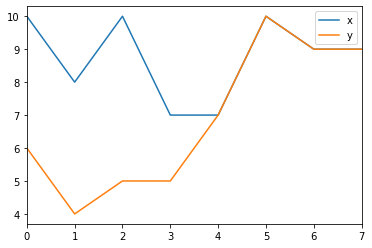

In [0]:
df.plot()

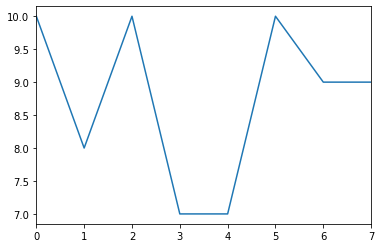

In [0]:
df['x'].plot()

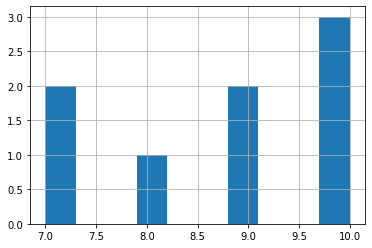

In [0]:
df['x'].hist()

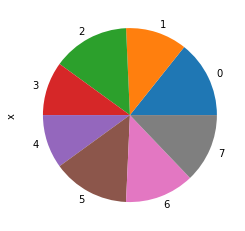

In [0]:
df['x'].plot(kind='pie')

In [0]:
from matplotlib import pyplot

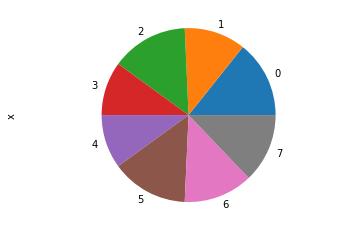

In [0]:
pyplot.axis('equal')
df['x'].plot(kind='pie')

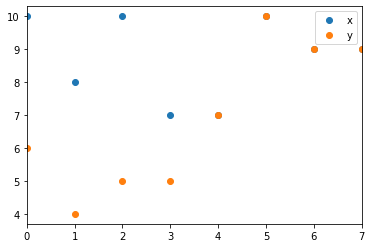

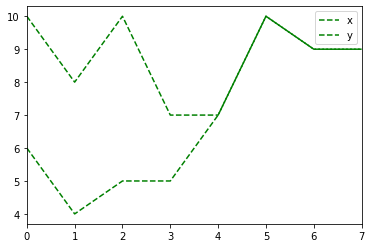

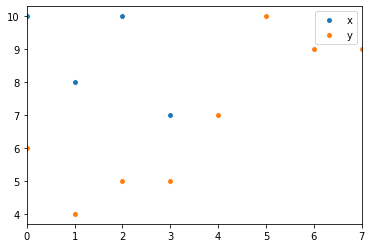

In [0]:
df.plot(style='o') # plot as dots, not lines
df.plot(style='g--') # plot as green dashed line
df.plot(style='o', markeredgecolor='white') # plot as dots with white edge


NameError: ignored

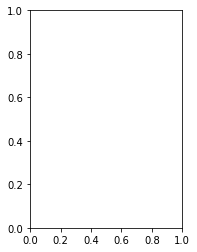

In [0]:
plt.figure() # create a new figure
ax = plt.subplot(121) # create the left-side subplot
df1.plot(ax=ax) # plot df1 on that subplot
ax = plt.subplot(122) # create the right-side subplot
df2.plot(ax=ax) # and plot df2 there
plt.show() # show the plot


# ***Chapter 15: Grouping Data***

In [0]:
df = pd.DataFrame({'A': ['a', 'b', 'c', 'a', 'b', 'b'], 'B': [2, 8, 1, 4, 3, 8], 'C': [102, 98, 107, 104, 115, 87]})

In [0]:
df

,A,B,C
0,a,2,102
1,b,8,98
2,c,1,107
3,a,4,104
4,b,3,115
5,b,8,87


In [0]:
df.groupby('A').mean()

,B,C
A,,
a,3.000000,103.0
b,6.333333,100.0
c,1.000000,107.0


In [0]:
df.groupby(['A','B']).mean()

C
A B       
a 2  102.0
  4  104.0
b 3  115.0
  8   92.5
c 1  107.0

In [0]:
df.groupby(['A','B']).agg(['count', 'mean'])

C       
    count   mean
A B             
a 2     1  102.0
  4     1  104.0
b 3     1  115.0
  8     2   92.5
c 1     1  107.0

In [0]:
import numpy as np
import pandas as pd

In [0]:
np.random.seed(0)
df = pd.DataFrame({'Age': np.random.randint(20, 70, 100), 'Sex': np.random.choice(['Male', 'Female'], 100), 'number_of_foo': np.random.randint(1, 20, 100)})

In [0]:
df.head()

,Age,Sex,number_of_foo
0,64,Female,14
1,67,Female,14
2,20,Female,12
3,23,Male,17
4,23,Female,15


In [0]:
pd.cut(df['Age'], bins=4)
# this creates four age groups: (19.951, 32.25] < (32.25, 44.5] < (44.5, 56.75] < (56.75, 69]

0       (56.75, 69.0]
1       (56.75, 69.0]
2     (19.951, 32.25]
3     (19.951, 32.25]
4     (19.951, 32.25]
           ...       
95      (32.25, 44.5]
96      (32.25, 44.5]
97      (32.25, 44.5]
98      (56.75, 69.0]
99      (56.75, 69.0]
Name: Age, Length: 100, dtype: category
Categories (4, interval[float64]): [(19.951, 32.25] < (32.25, 44.5] < (44.5, 56.75] < (56.75, 69.0]]

In [0]:
pd.cut(df['Age'], bins=[19, 40, 65, np.inf])
# this creates three age groups: (19, 40], (40, 65] and (65, infinity)

0     (40.0, 65.0]
1      (65.0, inf]
2     (19.0, 40.0]
3     (19.0, 40.0]
4     (19.0, 40.0]
          ...     
95    (19.0, 40.0]
96    (19.0, 40.0]
97    (40.0, 65.0]
98     (65.0, inf]
99     (65.0, inf]
Name: Age, Length: 100, dtype: category
Categories (3, interval[float64]): [(19.0, 40.0] < (40.0, 65.0] < (65.0, inf]]

In [0]:
age_groups = pd.cut(df['Age'], bins=[19, 40, 65, np.inf])
df.groupby(age_groups)['number_of_foo'].mean()

Age
(19.0, 40.0]    9.880000
(40.0, 65.0]    9.452381
(65.0, inf]     9.250000
Name: number_of_foo, dtype: float64

In [0]:
pd.crosstab(age_groups, df['Sex'])

Sex,Female,Male
Age,,
"(19.0, 40.0]",22,28
"(40.0, 65.0]",18,24
"(65.0, inf]",3,5


In [0]:
df = pd.DataFrame([[1, 1, 2], [1, 2, 3], [2, 3, 4]], columns=["A", "B", "C"])

In [0]:
df

,A,B,C
0,1,1,2
1,1,2,3
2,2,3,4


In [0]:
g = df.groupby("A")

In [0]:
g["B"].mean() # just column B

A
1    1.5
2    3.0
Name: B, dtype: float64

In [0]:
g[["B", "C"]].mean() # columns B and C

,B,C
A,,
1,1.5,2.5
2,3.0,4.0


In [0]:
g.agg({'B': 'mean', 'C': 'count'})

,B,C
A,,
1,1.5,2
2,3.0,1


In [0]:
df = pd.DataFrame({"Name":["Alice", "Bob", "Mallory", "Mallory", "Bob" , "Mallory"], "City":["Seattle", "Seattle", "Portland", "Seattle", "Seattle", "Portland"], "Val": [4, 3, 3, np.nan, np.nan, 4]})

In [0]:
df

,Name,City,Val
0,Alice,Seattle,4.0
1,Bob,Seattle,3.0
2,Mallory,Portland,3.0
3,Mallory,Seattle,NaN
4,Bob,Seattle,NaN
5,Mallory,Portland,4.0


In [0]:
df.groupby(["Name", "City"])['Val'].size().reset_index(name='Size')

,Name,City,Size
0,Alice,Seattle,1
1,Bob,Seattle,2
2,Mallory,Portland,2
3,Mallory,Seattle,1


In [0]:
df.groupby(["Name", "City"])['Val'].count().reset_index(name='Count')

,Name,City,Count
0,Alice,Seattle,1
1,Bob,Seattle,1
2,Mallory,Portland,2
3,Mallory,Seattle,0


In [0]:
import numpy as np
import pandas as pd

In [0]:
df = pd.DataFrame({'A': list('XYZXYZXYZX'), 'B': [1, 2, 1, 3, 1, 2, 3, 3, 1, 2], 'C': [12, 14, 11, 12, 13, 14, 16, 12, 10, 19]})

In [0]:
df.groupby('A')['B'].agg({'mean': np.mean, 'standard deviation': np.std})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


,mean,standard deviation
A,,
X,2.250000,0.957427
Y,2.000000,1.000000
Z,1.333333,0.577350


In [0]:
df.groupby('A').agg({'B': [np.mean, np.std], 'C': [np.sum, 'count']})

B             C      
       mean       std sum count
A                              
X  2.250000  0.957427  59     4
Y  2.000000  1.000000  39     3
Z  1.333333  0.577350  35     3

In [0]:
# Same example data as in the previous example.
import numpy as np
import pandas as pd

In [0]:
np.random.seed(0)


In [0]:
df = pd.DataFrame({'Age': np.random.randint(20, 70, 100),
'Sex': np.random.choice(['Male', factor 'Female'], 100),
'number_of_foo': np.random.randint(1, 20, 100)})

SyntaxError: ignored

In [0]:
# Export to Male.csv and Female.csv files.
for sex, data in df.groupby('Sex'):
  data.to_csv("{}.csv".format(sex))

KeyError: ignored

In [0]:
df = pd.DataFrame({'group1' : ['A', 'A', 'A', 'A',
                               'B', 'B', 'B', 'B'],
                    'group2' : ['C', 'C', 'C', 'D',
                        'E', 'E', 'F', 'F'],
                    'B' : ['one', np.NaN, np.NaN, np.NaN,
                        np.NaN, 'two', np.NaN, np.NaN],
                    'C' : [np.NaN, 1, np.NaN, np.NaN,
                        np.NaN, np.NaN, np.NaN, 4]})

In [0]:
df

,group1,group2,B,C
0,A,C,one,NaN
1,A,C,NaN,1.0
2,A,C,NaN,NaN
3,A,D,NaN,NaN
4,B,E,NaN,NaN
5,B,E,two,NaN
6,B,F,NaN,NaN
7,B,F,NaN,4.0


In [0]:
df['count_B']=df.groupby(['group1','group2']).B.transform('count')

In [0]:
df

,group1,group2,B,C,count_B
0,A,C,one,NaN,1
1,A,C,NaN,1.0,1
2,A,C,NaN,NaN,1
3,A,D,NaN,NaN,0
4,B,E,NaN,NaN,1
5,B,E,two,NaN,1
6,B,F,NaN,NaN,0
7,B,F,NaN,4.0,0


# ***Chapter 16: Grouping Time Series Data***

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# I want 7 days of 24 hours with 60 minutes each
periods = 7 * 24 * 60
tidx = pd.date_range('2016-07-01', periods=periods, freq='T')
# ^ ^
# | |
# Start Date Frequency Code for Minute
# This should get me 7 Days worth of minutes in a datetimeindex
# Generate random data with numpy. We'll seed the random
# number generator so that others can see the same results.
# Otherwise, you don't have to seed it.
np.random.seed([3,1415])
# This will pick a number of normally distributed random numbers
# where the number is specified by periods
data = np.random.randn(periods)
ts = pd.Series(data=data, index=tidx, name='HelloTimeSeries')
ts.describe()

count    10080.000000
mean        -0.008853
std          0.995411
min         -3.936794
25%         -0.683442
50%          0.002640
75%          0.654986
max          3.906053
Name: HelloTimeSeries, dtype: float64

In [0]:
# resample says to group by every 15 minutes. But now we need
# to specify what to do within those 15 minute chunks.
# We could take the last value.
ts.resample('15T').last()

2016-07-01 00:00:00   -0.911575
2016-07-01 00:15:00    0.831452
2016-07-01 00:30:00    1.258253
2016-07-01 00:45:00   -0.017209
2016-07-01 01:00:00    0.025249
                         ...   
2016-07-07 22:45:00   -0.112963
2016-07-07 23:00:00   -1.684835
2016-07-07 23:15:00   -0.268678
2016-07-07 23:30:00    1.097568
2016-07-07 23:45:00   -0.543848
Freq: 15T, Name: HelloTimeSeries, Length: 672, dtype: float64

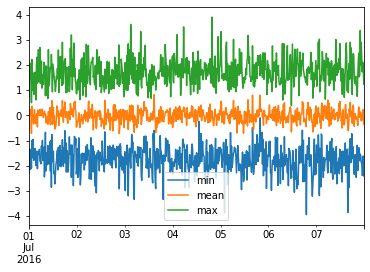

In [0]:
ts.resample('15T').agg(['min', 'mean', 'max']).plot()

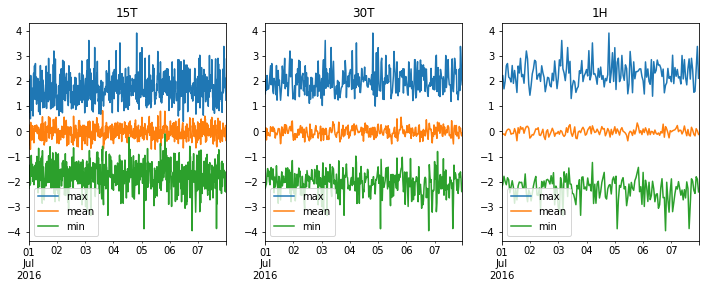

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, freq in enumerate(['15T', '30T', '1H']):
  ts.resample(freq).agg(['max', 'mean', 'min']).plot(ax=axes[i], title=freq)

# ***Chapter 17: Holiday Calendars***

In [0]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay
class FrBusinessCalendar(AbstractHolidayCalendar):
  """ Custom Holiday calendar for France based on
    https://en.wikipedia.org/wiki/Public_holidays_in_France
    - 1 January: New Year's Day
    - Moveable: Easter Monday (Monday after Easter Sunday)
    - 1 May: Labour Day
    - 8 May: Victory in Europe Day
    - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
    - 14 July: Bastille Day
    - 15 August: Assumption of Mary to Heaven
    - 1 November: All Saints' Day
    - 11 November: Armistice Day
    - 25 December: Christmas Day
  """
  rules = [
  Holiday('New Years Day', month=1, day=1),
  EasterMonday,
  Holiday('Labour Day', month=5, day=1),
  Holiday('Victory in Europe Day', month=5, day=8),
  Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
  Holiday('Bastille Day', month=7, day=14),
  Holiday('Assumption of Mary to Heaven', month=8, day=15),
  Holiday('All Saints Day', month=11, day=1),
  Holiday('Armistice Day', month=11, day=11),
  Holiday('Christmas Day', month=12, day=25)
  ]

In [0]:
import pandas as pd
from datetime import date

In [0]:
# Creating some boundaries
year = 2016
start = date(year, 1, 1)
end = start + pd.offsets.MonthEnd(12)

In [0]:
# Creating a custom calendar
cal = FrBusinessCalendar()
# Getting the holidays (off-days) between two dates
cal.holidays(start=start, end=end)
# DatetimeIndex(['2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05',
# '2016-05-08', '2016-07-14', '2016-08-15', '2016-11-01',
# '2016-11-11', '2016-12-25'],
# dtype='datetime64[ns]', freq=None)

DatetimeIndex(['2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05',
               '2016-05-08', '2016-07-14', '2016-08-15', '2016-11-01',
               '2016-11-11', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

In [0]:
from pandas.tseries.offsets import CDay
# Creating a series of dates between the boundaries
# by using the custom calendar
se = pd.bdate_range(start=start,
end=end,
freq=CDay(calendar=cal)).to_series()
# Counting the number of working days by month
se.groupby(se.dt.month).count().head()
# 1 20
# 2 21
# 3 22
# 4 21
# 5 21

1    20
2    21
3    22
4    21
5    21
dtype: int64

# ***Chapter 18: Indexing and selecting data***

In [0]:
# Create a sample DF
df = pd.DataFrame(np.random.randn(5, 3), columns=list('ABC'))

In [0]:
# Show DF
df

,A,B,C
0,2.059591,-0.379065,-0.135415
1,0.913717,0.287985,-0.134038
2,0.020426,1.407537,-0.002103
3,-0.248215,0.416876,-0.984787
4,-0.743571,0.010867,-1.649587


In [0]:
# Select column using a single label, 'A'
df['A']

0    2.059591
1    0.913717
2    0.020426
3   -0.248215
4   -0.743571
Name: A, dtype: float64

In [0]:
# Select multiple columns using an array of labels, ['A', 'C']
df[['A', 'C']]

,A,C
0,2.059591,-0.135415
1,0.913717,-0.134038
2,0.020426,-0.002103
3,-0.248215,-0.984787
4,-0.743571,-1.649587


In [0]:
df = pd.DataFrame([[11, 22], [33, 44], [55, 66]], index=list("abc"))

In [0]:
df

,0,1
a,11,22
b,33,44
c,55,66


In [0]:
df.iloc[0] # the 0th index (row)

0    11
1    22
Name: a, dtype: int64

In [0]:
df.iloc[1] # the 1st index (row)

0    33
1    44
Name: b, dtype: int64

In [0]:
df.iloc[:2] # the first 2 rows

,0,1
a,11,22
b,33,44


In [0]:
df[::-1] # reverse order of rows

,0,1
c,55,66
b,33,44
a,11,22


In [0]:
df.iloc[:, 1] # the 1st column

a    22
b    44
c    66
Name: 1, dtype: int64

In [0]:
import pandas as pd
import numpy as np
np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"), index = ["R" + str(i) for i in range(5)])

In [0]:
df

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80
R3,27,44,77,75,65
R4,47,30,84,86,18


In [0]:
df.loc['R0':'R2']

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80


In [0]:
df.loc['R0':'R2'] # rows labelled R0, R1, R2

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80


In [0]:
df.iloc[0:2] # rows indexed by 0, 1

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80


In [0]:
df.loc[:, 'C':'E']

,C,D,E
R0,61,16,73
R1,27,30,80
R2,15,53,80
R3,77,75,65
R4,84,86,18


In [0]:
import pandas as pd
import numpy as np
np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"), index = ["R" + str(i) for i in range(5)])

In [0]:
df

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80
R3,27,44,77,75,65
R4,47,30,84,86,18


In [0]:
df.ix[1:3, 'C':'E']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,C,D,E
R1,27,30,80
R2,15,53,80


In [0]:
df.index = np.arange(5, 10)

In [0]:
df

,A,B,C,D,E
5,99,78,61,16,73
6,8,62,27,30,80
7,7,76,15,53,80
8,27,44,77,75,65
9,47,30,84,86,18


In [0]:
import pandas as pd
import numpy as np
np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"), index = ["R" + str(i) for i in range(5)])

In [0]:
df

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80
R3,27,44,77,75,65
R4,47,30,84,86,18


In [0]:
mask = df['A'] > 10
print (mask)

R0     True
R1    False
R2    False
R3     True
R4     True
Name: A, dtype: bool


In [0]:
print (df[mask])

     A   B   C   D   E
R0  99  78  61  16  73
R3  27  44  77  75  65
R4  47  30  84  86  18


In [0]:
print (df.ix[mask, 'C'])

R0    61
R3    77
R4    84
Name: C, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


In [0]:
print(df.ix[mask, ['C', 'D']])

     C   D
R0  61  16
R3  77  75
R4  84  86


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


# ***generate sample DF***

In [0]:
df = pd.DataFrame(np.random.randint(0, 10, size=(5, 6)), columns=['a10','a20','a25','b','c','d'])

In [0]:
df

,a10,a20,a25,b,c,d
0,9,9,9,9,1,2
1,7,0,5,0,0,4
2,4,9,3,2,4,6
3,9,3,3,2,1,5
4,7,4,3,1,7,3


In [0]:
df.filter(like='a')

,a10,a20,a25
0,9,9,9
1,7,0,5
2,4,9,3
3,9,3,3
4,7,4,3


In [0]:
df.filter(regex='(b|c|d)')

,b,c,d
0,9,1,2
1,0,0,4
2,2,4,6
3,2,1,5
4,1,7,3


# ***show all columns except those beginning with a (in other word remove / drop all columns satisfying given RegEx)***

In [0]:
df.ix[:, ~df.columns.str.contains('^a')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,b,c,d
0,9,1,2
1,0,0,4
2,2,4,6
3,2,1,5
4,1,7,3


In [0]:
df.ix[:, ~df.columns.str.contains('^a')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,b,c,d
0,9,1,2
1,0,0,4
2,2,4,6
3,2,1,5
4,1,7,3


In [0]:
import pandas as pd

In [0]:
df = pd.DataFrame(np.random.randint(0,10,size=(10, 3)), columns=list('ABC'))

In [0]:
df

,A,B,C
0,1,9,5
1,7,0,9
2,6,0,5
3,2,8,6
4,8,0,5
5,2,0,7
6,7,6,0
7,0,8,5
8,5,9,6
9,4,5,2


In [0]:
#select rows where values in column A > 2 and values in column B < 5
df.query('A > 2 and B < 5')

,A,B,C
1,7,0,9
2,6,0,5
4,8,0,5


In [0]:
#using .query() method with variables for filtering
B_filter = [5,7]
df.query('B == @B_filter')

,A,B,C
9,4,5,2


In [0]:
df.query('@B_filter in B')

,A,B,C
9,4,5,2


In [0]:
#starting python community conventions
import numpy as np
import pandas as pd

In [0]:
# n is number of observations
n = 5000


In [0]:
day = pd.to_datetime(['2013-02-06'])
print(day)

DatetimeIndex(['2013-02-06'], dtype='datetime64[ns]', freq=None)


In [0]:
# irregular seconds spanning 28800 seconds (8 hours)
seconds = np.random.rand(n) * 28800 * pd.Timedelta(1, 's')
print(seconds)

[25854666531273 27323762321309 15472094244563 ... 16879996036435
 24939877521880  7841301913003]


In [0]:
# start at 8 am
start = pd.offsets.Hour(8)
print(start)

<8 * Hours>


In [0]:
# irregular timeseries
tidx = day + start + seconds

ValueError: ignored

In [0]:
s = pd.Series(np.random.randn(n), tidx, name='A').cumsum()
s.plot();

ValueError: ignored

In [0]:
def mover(s, move_size=10):
  """Given a reference, find next value with
  an absolute difference >= move_size"""
  ref = None
  for i, v in s.iteritems():
    if ref is None or (abs(ref - v) >= move_size):
      yield i, v
      ref = v

In [0]:
moves = pd.Series({i:v for i, v in mover(s, move_size=10)}, name='_{}_'.format(s.name))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb7cf0abdd8> has a label of '_None_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


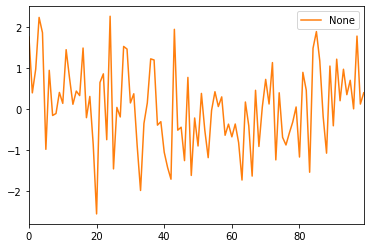

In [219]:
moves.plot(legend=True)
s.plot(legend=True)

In [0]:
def mover_df(df, col, move_size=2):
  ref = None
  for i, row in df.iterrows():
    if ref is None or (abs(ref - row.loc[col]) >= move_size):
      yield row
      ref = row.loc[col]


In [222]:
df = s.to_frame()
moves_df = pd.concat(mover_df(df, 'A', 10), axis=1).T



KeyError: ignored

In [223]:
moves_df.A.plot(label='_A_', legend=True)
df.A.plot(legend=True)

NameError: ignored

In [224]:
df.head(n)

,0
0,1.764052
1,0.400157
2,0.978738
3,2.240893
4,1.867558
...,...
95,0.706573
96,0.010500
97,1.785870
98,0.126912


In [226]:
df.tail(n)

,0
0,1.764052
1,0.400157
2,0.978738
3,2.240893
4,1.867558
...,...
95,0.706573
96,0.010500
97,1.785870
98,0.126912


In [228]:
df[:10] # same as df.head(10)

,0
0,1.764052
1,0.400157
2,0.978738
3,2.240893
4,1.867558
5,-0.977278
6,0.950088
7,-0.151357
8,-0.103219
9,0.410599


In [229]:
df[-10:] # same as df.tail(10)

,0
90,-0.403177
91,1.222445
92,0.208275
93,0.976639
94,0.356366
95,0.706573
96,0.010500
97,1.785870
98,0.126912
99,0.401989


In [0]:
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6]})

In [231]:
df

,col_1,col_2
0,A,3
1,B,4
2,A,3
3,B,5
4,C,6


In [232]:
df['col_1'].unique()

array(['A', 'B', 'C'], dtype=object)

In [233]:
df.drop_duplicates()

,col_1,col_2
0,A,3
1,B,4
3,B,5
4,C,6


In [0]:
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6], 'col_3':[0,0.1,0.2,0.3,0.4]})

In [235]:
df

,col_1,col_2,col_3
0,A,3,0.0
1,B,4,0.1
2,A,3,0.2
3,B,5,0.3
4,C,6,0.4


In [236]:
df.drop_duplicates()

,col_1,col_2,col_3
0,A,3,0.0
1,B,4,0.1
2,A,3,0.2
3,B,5,0.3
4,C,6,0.4


In [237]:
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6], 'col_3':[0,0.1,0.2,0.3,0.4]})
df.drop_duplicates(['col_1','col_2'])

,col_1,col_2,col_3
0,A,3,0.0
1,B,4,0.1
3,B,5,0.3
4,C,6,0.4


In [238]:
# skip last column
 df.drop_duplicates(['col_1','col_2'])[['col_1','col_2']]

,col_1,col_2
0,A,3
1,B,4
3,B,5
4,C,6


In [0]:
df = pd.DataFrame([[0,1,2,3], [None,5,None,pd.NaT], [8,None,10,None], [11,12,13,pd.NaT]],columns=list('ABCD'))

In [240]:
df

,A,B,C,D
0,0.0,1.0,2.0,3
1,NaN,5.0,NaN,NaT
2,8.0,NaN,10.0,None
3,11.0,12.0,13.0,NaT


In [241]:
df.dropna()

,A,B,C,D
0,0.0,1.0,2.0,3


In [242]:
df.dropna(subset=['C'])

,A,B,C,D
0,0.0,1.0,2.0,3
2,8.0,NaN,10.0,None
3,11.0,12.0,13.0,NaT


# ***Chapter 19: IO for Google BigQuery***

In [0]:
import pandas as pd

In [248]:
data = pd.read_gbq('''SELECT title, id, num_characters
 FROM [publicdata:samples.wikipedia]
 LIMIT 5''')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=7JFvDhYXxbTsQp2cDlNgtvXGeuThU4&prompt=consent&access_type=offline
Enter the authorization code: 4/vwHPGnLc2zmd__EG12pvPICqBvxNHSkqDzg1SXHHy66pSukOwmTDNJg


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 8))



ValueError: ignored

# ***Chapter 20: JSON***

In [249]:
pd.read_json('[{"A": 1, "B": 2}, {"A": 3, "B": 4}]')

,A,B
0,1,2
1,3,4


In [251]:
#/content/example_1.json
with open('/content/example_1.json') as f:
  data = pd.DataFrame(json.loads(line) for line in f)

NameError: ignored

In [0]:
def to_flare_json(df, filename):
  """Convert dataframe into nested JSON as in flare files used for D3.js"""
  flare = dict()
  d = {"name":"flare", "children": []}

  for index, row in df.iterrows():
    parent = row[0]
    child = row[1]
    child_size = row[2]

    # Make a list of keys
    key_list = []
    for item in d['children']:
      key_list.append(item['name'])

    #if 'parent' is NOT a key in flare.JSON, append it
    if not parent in key_list:
      d['children'].append({"name": parent, "children":[{"value": child_size, "name":
child}]})
    # if parent IS a key in flare.json, add a new child to it
    else:
      d['children'][key_list.index(parent)]['children'].append({"value": child_size,
"name": child})
    flare = d
    # export the final result to a json file
    with open(filename +'.json', 'w') as outfile:
      json.dump(flare, outfile, indent=4)
  return ("Done")

In [253]:
{"A": 1, "B": 2}
{"A": 3, "B": 4}

{'A': 3, 'B': 4}

In [254]:
pd.read_json('/content/example_1.json', lines=True)

ValueError: ignored

# ***Chapter 21: Making Pandas Play Nice With Native Python Datatypes***

In [0]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'], 'D': [True, False, True]})

In [256]:
df

,A,B,C,D
0,1,1.0,a,True
1,2,2.0,b,False
2,3,3.0,c,True


In [257]:
df['A'].tolist()

[1, 2, 3]

In [258]:
df.tolist()

AttributeError: ignored

In [259]:
df['B'].values

array([1., 2., 3.])

In [260]:
df.values

array([[1, 1.0, 'a', True],
       [2, 2.0, 'b', False],
       [3, 3.0, 'c', True]], dtype=object)

In [261]:
df['C'].to_dict()

{0: 'a', 1: 'b', 2: 'c'}

In [262]:
df.to_dict()

{'A': {0: 1, 1: 2, 2: 3},
 'B': {0: 1.0, 1: 2.0, 2: 3.0},
 'C': {0: 'a', 1: 'b', 2: 'c'},
 'D': {0: True, 1: False, 2: True}}

In [263]:
df.to_dict('records')

[{'A': 1, 'B': 1.0, 'C': 'a', 'D': True},
 {'A': 2, 'B': 2.0, 'C': 'b', 'D': False},
 {'A': 3, 'B': 3.0, 'C': 'c', 'D': True}]

# ***Chapter 22: Map Values***

In [0]:
d = {112: 'en', 113: 'es', 114: 'es', 111: 'en'}

In [265]:
d

{111: 'en', 112: 'en', 113: 'es', 114: 'es'}

In [266]:
df['S'] = df['U'].map(d)

KeyError: ignored

# ***Chapter 23: Merge, join, and concatenate***

In [267]:
df

,A,B,C,D
0,1,1.0,a,True
1,2,2.0,b,False
2,3,3.0,c,True


In [0]:
T1 = pd.DataFrame({'id' : [8, 9], 'x' : [42, 30], 'y' : [1.9, 1.9]})
T2 = pd.DataFrame({'id' : [8, 8, 8, 9, 9, 9], 'signal' : [55, 56, 59, 57, 58, 60]})
#df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'], 'D': [True, False, True]})

In [318]:
df1 = T1
T1 = T1.set_index('id')
T1

,x,y
id,,
8,42,1.9
9,30,1.9


In [319]:
T2 = T2.set_index('id')
T2

,signal
id,
8,55
8,56
8,59
9,57
9,58
9,60


In [320]:
df = T1.merge(T2.groupby('id')['signal'].apply(lambda x: x.reset_index(drop=True)).unstack().reset_index())

MergeError: ignored

In [0]:
df2 = pd.DataFrame({'id' : [8, 9], 'x' : [42, 30], 'y' : [1.9, 1.9], 0 : [55, 57], 1 : [56, 58], 2 : [59, 60]})

In [322]:
df2

,id,x,y,0,1,2
0,8,42,1.9,55,56,59
1,9,30,1.9,57,58,60


In [0]:
df2t = T2.groupby('id')['signal'].apply(lambda x: x.reset_index(drop=True)).unstack().reset_index()

In [324]:
df2t

,id,0,1,2
0,8,55,56,59
1,9,57,58,60


In [0]:
df = df1.merge(df2t)

In [327]:
df

,id,x,y,0,1,2
0,8,42,1.9,55,56,59
1,9,30,1.9,57,58,60


In [0]:
df1 = pd.DataFrame({'x': [1, 2, 3], 'y': ['a', 'b', 'c']})
df2 = pd.DataFrame({'y': ['b', 'c', 'd'], 'z': [4, 5, 6]})

In [329]:
df1

,x,y
0,1,a
1,2,b
2,3,c


In [330]:
df2

,y,z
0,b,4
1,c,5
2,d,6


In [331]:
df1.merge(df2) # by default, it does an inner join on the common column(s)

,x,y,z
0,2,b,4
1,3,c,5


In [0]:
merged_inner = pd.merge(left=df1, right=df2, left_on='y', right_on='y')

In [333]:
merged_inner

,x,y,z
0,2,b,4
1,3,c,5


In [334]:
df1.merge(df2, how='outer')

,x,y,z
0,1.0,a,NaN
1,2.0,b,4.0
2,3.0,c,5.0
3,NaN,d,6.0


In [335]:
df1.merge(df2, how='left')

,x,y,z
0,1,a,NaN
1,2,b,4.0
2,3,c,5.0


In [336]:
df1.merge(df2, how='right')

,x,y,z
0,2.0,b,4
1,3.0,c,5
2,NaN,d,6


In [0]:
df3 = pd.DataFrame({'col1':[211,212,213], 'col2': [221,222,223]})

In [338]:
df3

,col1,col2
0,211,221
1,212,222
2,213,223


In [0]:
df1 = pd.DataFrame({'col1':[11,12,13], 'col2': [21,22,23]})

In [0]:
df2 = pd.DataFrame({'col1':[111,112,113], 'col2': [121,122,123]})

In [0]:
df3 = pd.DataFrame({'col1':[211,212,213], 'col2': [221,222,223]})

In [342]:
df1

,col1,col2
0,11,21
1,12,22
2,13,23


In [343]:
df2

,col1,col2
0,111,121
1,112,122
2,113,123


In [344]:
df3

,col1,col2
0,211,221
1,212,222
2,213,223


In [345]:
pd.concat([df1,df2,df3], ignore_index=True)

,col1,col2
0,11,21
1,12,22
2,13,23
3,111,121
4,112,122
5,113,123
6,211,221
7,212,222
8,213,223


In [346]:
pd.concat([df1,df2,df3], axis=1)

,col1,col2,col1,col2,col1,col2
0,11,21,111,121,211,221
1,12,22,112,122,212,222
2,13,23,113,123,213,223


In [347]:
pd.merge(df1, df2, on='key')

KeyError: ignored

In [348]:
pd.merge(df1, df2, left_on='l_key', right_on='r_key')

KeyError: ignored

In [349]:
pd.merge(df1, df2, on='key', how='left')

KeyError: ignored

In [350]:
pd.merge(df1, df2, on=['key1', 'key2'])

KeyError: ignored

In [351]:
pd.merge(df1, df2, on='key', suffixes=('_left', '_right'))

KeyError: ignored

In [352]:
pd.merge(df1, df2, right_index=True, left_index=True)

,col1_x,col2_x,col1_y,col2_y
0,11,21,111,121
1,12,22,112,122
2,13,23,113,123


In [353]:
pd.merge(df1, df2, right_index=True, left_on='l_key')

KeyError: ignored

In [354]:
pd.concat([df1, df2, df3], axis=0)

,col1,col2
0,11,21
1,12,22
2,13,23
0,111,121
1,112,122
2,113,123
0,211,221
1,212,222
2,213,223


In [355]:
pd.concat([df1, df2, df3], axis=1)

,col1,col2,col1,col2,col1,col2
0,11,21,111,121,211,221
1,12,22,112,122,212,222
2,13,23,113,123,213,223


In [0]:
left = pd.DataFrame([['a', 1], ['b', 2]], list('XY'), list('AB'))

In [357]:
left

,A,B
X,a,1
Y,b,2


In [0]:
right = pd.DataFrame([['a', 3], ['b', 4]], list('XY'), list('AC'))

In [359]:
right

,A,C
X,a,3
Y,b,4


In [360]:
left.join(right, lsuffix='_')

,A_,B,A,C
X,a,1,a,3
Y,b,2,b,4


In [361]:
left.join(right.reset_index(), lsuffix='_', how='outer')

,A_,B,index,A,C
X,a,1.0,NaN,NaN,NaN
Y,b,2.0,NaN,NaN,NaN
0,NaN,NaN,X,a,3.0
1,NaN,NaN,Y,b,4.0


In [362]:
left.reset_index().join(right, on='index', lsuffix='_')

,index,A_,B,A,C
0,X,a,1,a,3
1,Y,b,2,b,4


In [363]:
left.merge(right)

,A,B,C
0,a,1,3
1,b,2,4


In [364]:
left.merge(right, left_index=True, right_index=True, suffixes=['_', ''])

,A_,B,A,C
X,a,1,a,3
Y,b,2,b,4


# ***Chapter 24: Meta: Documentation Guidelines***

In [0]:
df = pd.DataFrame([[1, 2], [3, 4]])

In [366]:
df

,0,1
0,1,2
1,3,4


In [367]:
df.columns # Out: RangeIndex(start=0, stop=2, step=1)

RangeIndex(start=0, stop=2, step=1)

In [368]:
df[0]

0    1
1    3
Name: 0, dtype: int64

In [369]:
for col in df:
  print(col)

0
1


In [370]:
[print(col) for col in df]

0
1


[None, None]

In [0]:
import pandas as pd

In [372]:
a

NameError: ignored

In [373]:
print(a)

NameError: ignored

In [375]:
print(x) # yes! (works same in python 2 and 3)
#print x # no! (python 2 only)
print(x, y) # no! (works differently in python 2 and 3)


NameError: ignored

# ***Chapter 25: Missing Data***

In [0]:
df = pd.DataFrame([[1, 2, None, 3], [4, None, 5, 6], [7, 8, 9, 10], [None, None, None, None]])

In [377]:
df

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,NaN,5.0,6.0
2,7.0,8.0,9.0,10.0
3,NaN,NaN,NaN,NaN


In [378]:
df.fillna(0)

,0,1,2,3
0,1.0,2.0,0.0,3.0
1,4.0,0.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,0.0,0.0,0.0,0.0


In [379]:
df.fillna(method='pad') # this is equivalent to both method='ffill' and .ffill()

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,2.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,7.0,8.0,9.0,10.0


In [380]:
df.fillna(method='bfill') # this is equivalent to .bfill()

,0,1,2,3
0,1.0,2.0,5.0,3.0
1,4.0,8.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,NaN,NaN,NaN,NaN


In [0]:
df2 = pd.DataFrame(np.arange(100, 116).reshape(4, 4))

In [382]:
df2

,0,1,2,3
0,100,101,102,103
1,104,105,106,107
2,108,109,110,111
3,112,113,114,115


In [383]:
df.fillna(df2) # takes the corresponding cells in df2 to fill df

,0,1,2,3
0,1.0,2.0,102.0,3.0
1,4.0,105.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,112.0,113.0,114.0,115.0


In [0]:
df = pd.DataFrame([[1, 2, None, 3], [4, None, 5, 6], [7, 8, 9, 10], [None, None, None, None]])

In [391]:
df

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,NaN,5.0,6.0
2,7.0,8.0,9.0,10.0
3,NaN,NaN,NaN,NaN


In [392]:
df.dropna()

,0,1,2,3
2,7.0,8.0,9.0,10.0


In [394]:
df.dropna(how='all')

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,NaN,5.0,6.0
2,7.0,8.0,9.0,10.0


In [395]:
df.dropna(axis=1, thresh=3)

,0,3
0,1.0,3.0
1,4.0,6.0
2,7.0,10.0
3,NaN,NaN


In [397]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'A':[1,2,np.nan,3,np.nan], 'B':[1.2,7,3,0,8]})

df['C'] = df.A.interpolate()
df['D'] = df.A.interpolate(method='spline', order=1)

print (df)

     A    B    C         D
0  1.0  1.2  1.0  1.000000
1  2.0  7.0  2.0  2.000000
2  NaN  3.0  2.5  2.428571
3  3.0  0.0  3.0  3.000000
4  NaN  8.0  3.0  3.714286


In [398]:
import numpy as np
import pandas as pd
ser = pd.Series([1, 2, np.nan, 4])
pd.isnull(ser)

0    False
1    False
2     True
3    False
dtype: bool

In [399]:
ser == np.nan

0    False
1    False
2    False
3    False
dtype: bool

In [400]:
ser.isnull()

0    False
1    False
2     True
3    False
dtype: bool

In [0]:
df = pd.DataFrame({'A': [1, np.nan, 3], 'B': [np.nan, 5, 6]})

In [402]:
print(df)

     A    B
0  1.0  NaN
1  NaN  5.0
2  3.0  6.0
